In [1]:
%pip install --upgrade pip
%pip install --upgrade pandas
%pip install --upgrade numpy
%pip install --upgrade matplotlib
%pip install --upgrade seaborn
%pip install --upgrade cython

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
from owlready2 import *
# Load the BTO ontology
onto_path.append('../../data/ontologies/')
onto = get_ontology('http://purl.obolibrary.org/obo/bto.owl').load()

# classes dictionary: {class_name: class_label} 
#   - class_label is None if no label is found
classes = {c.name: c.label.first() for c in onto.classes()}
bto_objects = {c.name: c for c in onto.classes()}
bto_objects_rev = {c: c.name for c in onto.classes()}

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation




In [4]:
bto_immediate_children = {c.name: set() for c in onto.classes()}

# generate the immediate children of each class
for bto_class in bto_objects_rev:
    for bto_parent_class in bto_class.is_a:
        if bto_parent_class == owl.Thing:
            # ignore the root class
            continue
        else:
            bto_class_type = type(bto_parent_class)
            if bto_class_type == ThingClass:
                bto_immediate_children[bto_parent_class.name].add(bto_class.name)
            elif bto_class_type == Restriction:
                # Restriction 2202 defines a derives_from/develops_from relationship
                bto_immediate_children[bto_parent_class.value.name].add(bto_class.name)

In [5]:
def get_all_children(bto_immediate_children, bto_class):
    '''
    helper function to get all children of a given class by recursing down the tree
    - base case for recursion when value for the class in bto_children is empty
    - recursive case for recursion when value for the class in bto_children is not empty
    - returns a set of all children of the given class
    '''
    if not bto_immediate_children[bto_class]:
        return set()
    else:
        children = set()
        for child in bto_immediate_children[bto_class]:
            children.add(child)
            children = children.union(get_all_children(bto_immediate_children, child))
        return children


bto_children = {c.name: set() for c in onto.classes()}

for bto_class, _ in bto_immediate_children.items():
    bto_children[bto_class] = get_all_children(bto_immediate_children, bto_class)

Searching 'system' in EBI gives 52 hits including "immune system", "neuromuscular system", "cardiovascular system", ...

https://www.ebi.ac.uk/ols4/search?q=system&ontology=bto


- Can use the 52 terms and their children as a starting place to classify tissue results

----
# Exploring annotations for the SRA runs in Postgres

In [7]:
sra_runs_df = pd.read_csv('../../../data/sra_runs.csv')
sra_runs_df.head()

,run,bio_sample,bio_project
0,ERR2076986,SAMEA6045418,PRJEB19199
1,ERR2076987,SAMEA6104668,PRJEB19199
2,ERR2076988,SAMEA6104668,PRJEB19199
3,ERR2076989,SAMEA6104668,PRJEB19199
4,ERR2076990,SAMEA6104668,PRJEB19199


In [8]:
# load the results of the tissue_map into a single dataframe 
tissue_df_1 = pd.read_json('../../../data/results/tissue_output_1_rerun.jsonl', lines=True)
tissue_df_2 = pd.read_json('../../../data/results/tissue_output_2_rerun.jsonl', lines=True)
tissue_df = pd.concat([tissue_df_1, tissue_df_2])[['biosample_id', 'tissue', 'bto_matches']]
tissue_df.head()

,biosample_id,tissue,bto_matches
0,SAMN00000360,liver,BTO_0000759
1,SAMN00000361,kidney,BTO_0000671
2,SAMN00000528,b lymphocyte cell line,BTO_0001522
3,SAMN00000797,ht 29,BTO_0000182
4,SAMN00000798,ht 29,BTO_0000182


In [9]:
# merge the two dataframes on the biosample_id and bio_sample columns
# if there is no hit in tissue_df, NaN will be inserted for the 3 columns
sra_runs_df = pd.merge(sra_runs_df, tissue_df, how='left', right_on='biosample_id', left_on='bio_sample')
sra_runs_df.head()

,run,bio_sample,bio_project,biosample_id,tissue,bto_matches
0,ERR2076986,SAMEA6045418,PRJEB19199,SAMEA6045418,vas deferens,BTO_0001427
1,ERR2076987,SAMEA6104668,PRJEB19199,SAMEA6104668,embryo,BTO_0001233
2,ERR2076988,SAMEA6104668,PRJEB19199,SAMEA6104668,embryo,BTO_0001233
3,ERR2076989,SAMEA6104668,PRJEB19199,SAMEA6104668,embryo,BTO_0001233
4,ERR2076990,SAMEA6104668,PRJEB19199,SAMEA6104668,embryo,BTO_0001233


In [14]:
def unpack_tissues(dict_list, row):
    '''
    helper function to unpack comma separated tissues and add them to a dataframe
    must use bio_sample as the biosample id due to missing tissue values 
    '''
    matches = row['bto_matches']
    if type(matches) == str:
        for match in matches.split('\t'):
            dict_list.append({'run': row['run'], 'biosample_id': row['bio_sample'], 'bioproject_id': row['bio_project'], 'tissue': classes[match], 'bto_match': match})
    else:
        dict_list.append({'run': row['run'], 'biosample_id': row['bio_sample'], 'bioproject_id': row['bio_project'], 'tissue': np.nan, 'bto_match': np.nan})


sra_run_dict_list = []
_ = sra_runs_df.apply(lambda row: unpack_tissues(sra_run_dict_list, row), axis=1)

In [15]:
sra_runs_df_unpacked = pd.DataFrame(sra_run_dict_list)
sra_runs_df_unpacked.head()

,run,biosample_id,bioproject_id,tissue,bto_match
0,ERR2076986,SAMEA6045418,PRJEB19199,vas deferens,BTO_0001427
1,ERR2076987,SAMEA6104668,PRJEB19199,plant embryo,BTO_0001233
2,ERR2076988,SAMEA6104668,PRJEB19199,plant embryo,BTO_0001233
3,ERR2076989,SAMEA6104668,PRJEB19199,plant embryo,BTO_0001233
4,ERR2076990,SAMEA6104668,PRJEB19199,plant embryo,BTO_0001233


In [48]:
sra_runs_df_unpacked[sra_runs_df_unpacked['tissue'].isna()].head()

,run,biosample_id,bioproject_id,tissue,bto_match
1315,ERR2078287,SAMEA104200240,PRJEB22058,NaN,NaN
1316,ERR2078288,SAMEA104200241,PRJEB22058,NaN,NaN
1317,ERR2078289,SAMEA104200242,PRJEB22058,NaN,NaN
1318,ERR2078290,SAMEA104200243,PRJEB22058,NaN,NaN
1319,ERR2078291,SAMEA104200244,PRJEB22058,NaN,NaN


In [16]:
print('Number of unique bioprojects: ', len(set(sra_runs_df_unpacked['bioproject_id'])))
print('Number of unique biosamples: ', len(set(sra_runs_df_unpacked['biosample_id'])))
print('Number of unique runs: ', len(set(sra_runs_df_unpacked['run'])))

Number of unique bioprojects:  191679
Number of unique biosamples:  5783686
Number of unique runs:  7680426


Search for 'system' in the bto class labels gives 42 classes annotated as system

In [115]:
from pprint import pprint
system_classes = {i[0]:i[1] for i in list(classes.items()) if i[1] is not None and 'system' in i[1]}
pprint(system_classes)

{'BTO_0000081': 'reproductive system',
 'BTO_0000082': 'male reproductive system',
 'BTO_0000083': 'female reproductive system',
 'BTO_0000088': 'cardiovascular system',
 'BTO_0000136': 'bronchoalveolar system',
 'BTO_0000203': 'respiratory system',
 'BTO_0000227': 'central nervous system',
 'BTO_0000570': 'hematopoietic system',
 'BTO_0000831': 'liver reticuloendothelial system',
 'BTO_0000928': 'limbic system',
 'BTO_0001028': 'peripheral nervous system',
 'BTO_0001085': 'vascular system',
 'BTO_0001174': 'reticuloendothelial system',
 'BTO_0001266': 'invertebrate muscular system',
 'BTO_0001369': 'vertebrate muscular system',
 'BTO_0001484': 'nervous system',
 'BTO_0001485': 'muscular system',
 'BTO_0001486': 'skeletal system',
 'BTO_0001832': 'sympathetic nervous system',
 'BTO_0001833': 'parasympathetic nervous system',
 'BTO_0002017': 'plant reproductive system',
 'BTO_0002125': 'water vascular system',
 'BTO_0002506': 'enteric nervous system',
 'BTO_0002507': 'autonomic nervous 

Some classes that are annotated for 'system' are subsets of other systems and may have no children
    
- systems that are subclasses of other systems can be ignored for now.

In [116]:
all_system_children = set()
for system in system_classes:
    all_system_children = all_system_children.union(bto_children[system])

# prints all bto system classes that are children of other system classes
for a in all_system_children.intersection(set(system_classes.keys())):
    print(a, system_classes[a])

system_classes_system_children = {}

for system in system_classes:
    system_classes_system_children[system] = bto_children[system].intersection(set(system_classes.keys()))

BTO_0005591 mesolimbic dopaminergic system
BTO_0000227 central nervous system
BTO_0005593 mesocorticolimbic dopaminergic system
BTO_0001085 vascular system
BTO_0001266 invertebrate muscular system
BTO_0001174 reticuloendothelial system
BTO_0000928 limbic system
BTO_0004692 venous system
BTO_0001369 vertebrate muscular system
BTO_0000083 female reproductive system
BTO_0006157 olivocerebellar fiber system
BTO_0005606 precerebellar system
BTO_0002506 enteric nervous system
BTO_0006567 neuromuscular system
BTO_0003954 dopaminergic system
BTO_0005592 mesocortical dopaminergic system
BTO_0000136 bronchoalveolar system
BTO_0006153 nigrostriatal system
BTO_0000082 male reproductive system
BTO_0003092 urinary system
BTO_0002507 autonomic nervous system
BTO_0003840 cerebrovascular system
BTO_0003870 insect tracheal system
BTO_0001833 parasympathetic nervous system
BTO_0000831 liver reticuloendothelial system
BTO_0001028 peripheral nervous system
BTO_0000081 reproductive system
BTO_0001832 sympat

In [117]:
# take out the systems that are children of other systems
system_classes = {k:v for k,v in system_classes.items() if k not in all_system_children.intersection(set(system_classes.keys()))}
# takes out some important classes
#   - central nervous system
#   - vascular system
#   - limbic system
#   - reproductive system



# get all the children of the system classes
system_class_all_children = set()
system_class_children = {}
for system in system_classes:
    system_class_all_children = system_class_all_children.union(bto_children[system])
    system_class_children[system] = bto_children[system]
    # store the system children fdor each system


# reverse the mapping for the system_class_children dictionary
system_class_children_rev = {}
for system, children in system_class_children.items():
    for child in children:
        if child in system_class_children_rev:
            system_class_children_rev[child].append(system)
        else:
            system_class_children_rev[child] = [system]
# SOME CHILDREN CAN BE MAPPED TO MULTIPLE SYSTEMS




print("number of system classes: ", len(system_classes))
print("number of system class children: ", len(system_class_all_children))


number of system classes:  13
number of system class children:  3572


In [118]:
system_hits = sra_runs_df_unpacked[sra_runs_df_unpacked['bto_match'].isin(system_class_all_children)]
system_hits.head()

# add a column for the system class
system_hits['system'] = system_hits['bto_match'].apply(lambda x: system_class_children_rev[x][0])

# unpacks the system class into separate rows
system_hits = system_hits.explode('system')

# add the system class label
system_hits['system_label'] = system_hits['system'].apply(lambda x: classes[x])

system_hits.head()

/tmp/ipykernel_3906/4134500830.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  system_hits['system'] = system_hits['bto_match'].apply(lambda x: system_class_children_rev[x][0])


,run,biosample_id,bioproject_id,tissue,bto_match,system,system_label
0,ERR2076986,SAMEA6045418,PRJEB19199,vas deferens,BTO_0001427,BTO_0003091,urogenital system
66,ERR2077050,SAMEA6181168,PRJEB19199,brain,BTO_0000142,BTO_0001484,nervous system
69,ERR2077051,SAMEA6181168,PRJEB19199,brain,BTO_0000142,BTO_0001484,nervous system
72,ERR2077052,SAMEA6181168,PRJEB19199,brain,BTO_0000142,BTO_0001484,nervous system
75,ERR2077053,SAMEA6181168,PRJEB19199,brain,BTO_0000142,BTO_0001484,nervous system


Text(0.5, 1.0, 'Number of SRA Runs per System')

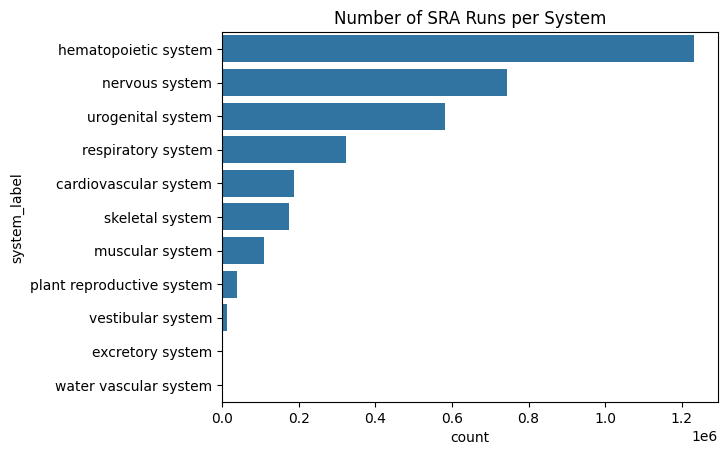

In [119]:
# create a seaboen countplot of the number of hits for each system and order by the count
ax = sns.countplot(y='system_label', data=system_hits, order=system_hits['system_label'].value_counts().index)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Number of SRA Runs per System')

In [126]:
print("system classes that are subsets of other system classes: ")
for s, s_children in system_classes_system_children.items():
    if s_children != set():
        print(classes[s], ":")
        for c in s_children:
            print("\t", classes[c])
        print()

system classes that are subsets of other system classes: 
reproductive system :
	 male reproductive system
	 female reproductive system

cardiovascular system :
	 venous system
	 cerebrovascular system
	 vascular system
	 arterial system

respiratory system :
	 insect tracheal system
	 bronchoalveolar system

central nervous system :
	 limbic system
	 precerebellar system

hematopoietic system :
	 liver reticuloendothelial system
	 reticuloendothelial system

peripheral nervous system :
	 sympathetic nervous system
	 parasympathetic nervous system

vascular system :
	 venous system
	 cerebrovascular system
	 arterial system

reticuloendothelial system :
	 liver reticuloendothelial system

nervous system :
	 mesolimbic dopaminergic system
	 limbic system
	 parasympathetic nervous system
	 dopaminergic system
	 mesocortical dopaminergic system
	 mesocorticolimbic dopaminergic system
	 peripheral nervous system
	 olivocerebellar fiber system
	 precerebellar system
	 nigrostriatal system
	